In [1]:
import warnings; warnings.simplefilter('ignore')

import re
import string
import timeit
import pickle
import random
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn_crfsuite import CRF
from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
# Number of examples
N = 5000
# Length of a feature
d = 128

In [3]:
def l2i(a):
        return int(ord(a)-ord('a'))
def i2l(i):
    if i >= 0:
        return chr(i+ord('a'))
    else:
        return '_'
def iors(s):
    try:
        return int(s)
    except ValueError: # if it is a string, return a string
        return s

In [4]:
def read_OCR(filename, n_features):
    F = open(filename)
    dataset = {}
    dataset['ids'] = []#np.zeros(n_examples, dtype=int)
    dataset['labels'] = []#np.zeros(n_examples,dtype=int)
    dataset['labelDic'] = {} # To profile the distribution of labels
    dataset['next_ids'] = []#np.zeros(n_examples,dtype=int)
    dataset['word_ids'] = []#np.zeros(n_examples,dtype=int)
    dataset['positions'] = []#np.zeros(n_examples,dtype=int)
    dataset['folds'] = []#np.zeros(n_examples,dtype=int)
    dataset['features'] = []#np.zeros([n_examples,n_features])
    
    for str_line in F.readlines():
        #line0 = map(iors, filter(None, re.split('\t', str_line.strip())))
        ## ATTENTION: If you are using Python3, use the following line instead
        line0 = list(map(iors, filter(None, re.split('\t', str_line.strip()))))


        dataset['ids'].append(int(line0.pop(0)))
        dataset['labels'].append(l2i(line0.pop(0))) # The label is converted into integer('a'=>0, 'z'=>25)
        if dataset['labels'][-1] in dataset['labelDic']:
            dataset['labelDic'][dataset['labels'][-1]] += 1
        else:
            dataset['labelDic'][dataset['labels'][-1]] = 1
            
        dataset['next_ids'].append(int(line0.pop(0)))
        dataset['word_ids'].append(int(line0.pop(0)))
        dataset['positions'].append(int(line0.pop(0)))
        dataset['folds'].append(int(line0.pop(0)))
        if len(line0) != 128:  # Sanity check of the length
            print (len(line0))
        dataset['features'].append(line0)

    return dataset

In [5]:
def format(dataset, N, L):
    # Group by words
    words = defaultdict(lambda: {'features': [], 'labels': []})
    for i in range(len(dataset['features'])):
        word_id = dataset['word_ids'][i]
        feats = dataset['features'][i]
        label = dataset['labels'][i]
        words[word_id]['features'].append(feats)
        words[word_id]['labels'].append(label)
    
    all_X = []
    all_y = []
    all_id = []

    # Flatten into list of full-word sequences
    for word_id in words.keys():
        word = words[word_id]
        word_feats = word['features']
        word_labels = word['labels']
        n = len(word_feats)

        if n < L:
            continue

        feats_seq = []

        for i in range(n):
            feat_dict = {}
            for offset in range(-(L // 2), L // 2 + 1):
                pos = i + offset
                if 0 <= pos < n:
                    prefix = f"{offset:+}"
                    for j, val in enumerate(word_feats[pos]):
                        feat_dict[f"{prefix}_{j}"] = val
            feats_seq.append(feat_dict)
        
        all_X.append(feats_seq)
        all_y.append(word_labels)
        all_id.append(word_id)

    # Randomly sample N sequences
    combined = list(zip(all_X, all_y, all_id))
    random.shuffle(combined)
    combined = combined[:N]
    X, y, ids = zip(*combined)

    return list(X), list(y), list(ids)

In [6]:
def showFeatures(features, true_labels, predicted_labels, num=20):
    plt.figure(figsize=(num, 4))

    for i in range(num):
        npfeature = np.array(features[i])
        image = npfeature.reshape(16, 8)

        true_char = true_labels[i]
        pred_char = predicted_labels[i]

        plt.subplot(1, num, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"T:{true_char}\nP:{pred_char}", fontsize=8)
        plt.axis('off')

    plt.suptitle("Character Predictions — T: Truth, P: Predicted", fontsize=12)
    plt.tight_layout()
    plt.show()

In [7]:
dataset = read_OCR('OCRdataset/letter.data', d)

In [8]:
wordid_to_indices = defaultdict(list)
for idx, wid in enumerate(dataset['word_ids']):
    wordid_to_indices[wid].append(idx)

## L = 1

In [9]:
L = 1

### 4000/1000

In [10]:
features, labels, ids = format(dataset, N, L)
TRAIN = 0.8
model_path = 'crf1_82.obj'

In [11]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = ids[:int(N * TRAIN)], ids[int(N * TRAIN):]

X_train_chars = [seq[:L] for seq in X_train]
X_test_chars = [seq[:L] for seq in X_test]
y_train_chars = [seq[:L] for seq in y_train]
y_test_chars = [seq[:L] for seq in y_test]

y_train = [[i2l(label) for label in seq] for seq in y_train]
y_test = [[i2l(label) for label in seq] for seq in y_test]
y_train_chars = [[i2l(label) for label in seq] for seq in y_train_chars]
y_test_chars = [[i2l(label) for label in seq] for seq in y_test_chars]

In [12]:
crf = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True,
)

start_train = timeit.default_timer()
crf.fit(X_train_chars, y_train_chars)
end_train = timeit.default_timer()
print(f"Training time elapsed: {end_train - start_train:.2f} s")

with open(model_path, 'wb') as f:
    pickle.dump(crf, f)

Training time elapsed: 2.08 s


Training accuracy: 0.8755
Testing time elapsed: 0.04 s
Testing accuracy: 0.8060
Full word accuracy: 0.0550


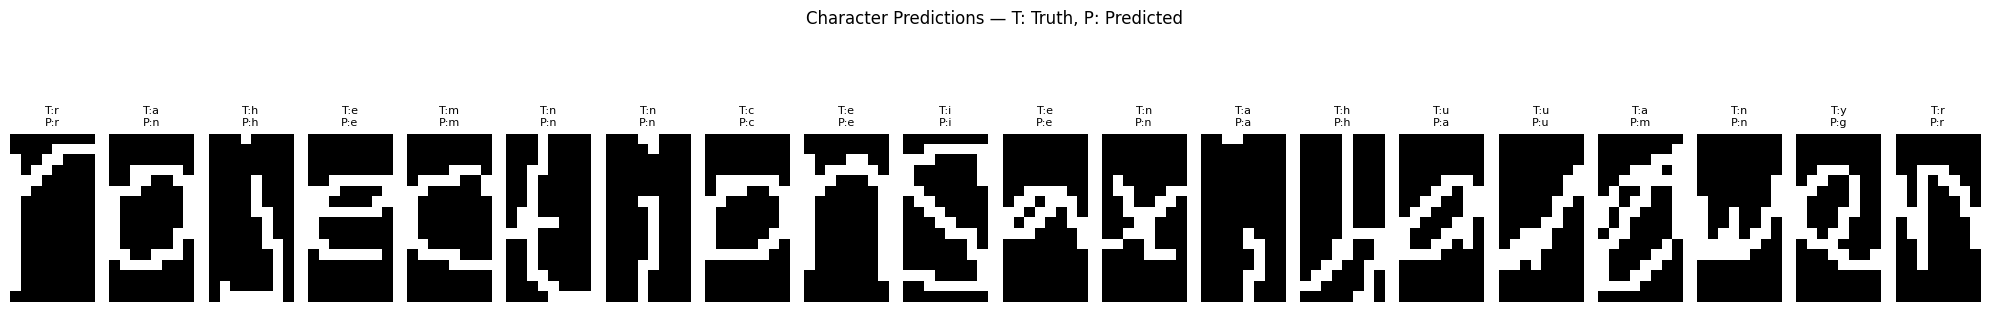

In [13]:
with open(model_path, 'rb') as f:
    crf = pickle.load(f)

# Training Accuracy
y_train_pred = crf.predict(X_train_chars)
y_train_true_flat = [label for seq in y_train_chars for label in seq]
y_train_pred_flat = [label for seq in y_train_pred for label in seq]

train_acc = accuracy_score(y_train_true_flat, y_train_pred_flat)
print(f"Training accuracy: {train_acc:.4f}")

# Testing Accuracy
start_test = timeit.default_timer()
y_pred = crf.predict(X_test_chars)
end_test = timeit.default_timer()
print(f"Testing time elapsed: {end_test - start_test:.2f} s")

y_test_true_flat = [label for seq in y_test_chars for label in seq]
y_test_pred_flat = [label for seq in y_pred for label in seq]

test_acc = accuracy_score(y_test_true_flat, y_test_pred_flat)
print(f"Testing accuracy: {test_acc:.4f}")

# Full word accuracy
y_pred = crf.predict(X_test)
correct = sum(yt == yp for yt, yp in zip(y_test, y_pred))
word_accuracy = correct / len(y_test)
print(f"Full word accuracy: {word_accuracy:.4f}")

features_flat = []
for wid in id_test:
    char_indices = wordid_to_indices[wid]
    for idx in char_indices:
        features_flat.append(dataset['features'][idx])
showFeatures(features_flat, y_test_true_flat, y_test_pred_flat, num=20)

### 2500/2500

In [14]:
features, labels, ids = format(dataset, N, L)
TRAIN = 0.5
model_path = 'crf1_55.obj'

In [15]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = ids[:int(N * TRAIN)], ids[int(N * TRAIN):]

X_train_chars = [seq[:L] for seq in X_train]
X_test_chars = [seq[:L] for seq in X_test]
y_train_chars = [seq[:L] for seq in y_train]
y_test_chars = [seq[:L] for seq in y_test]

y_train = [[i2l(label) for label in seq] for seq in y_train]
y_test = [[i2l(label) for label in seq] for seq in y_test]
y_train_chars = [[i2l(label) for label in seq] for seq in y_train_chars]
y_test_chars = [[i2l(label) for label in seq] for seq in y_test_chars]

In [16]:
crf = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True,
)

start_train = timeit.default_timer()
crf.fit(X_train_chars, y_train_chars)
end_train = timeit.default_timer()
print(f"Training time elapsed: {end_train - start_train:.2f} s")

with open(model_path, 'wb') as f:
    pickle.dump(crf, f)

Training time elapsed: 1.16 s


Training accuracy: 0.8932
Testing time elapsed: 0.08 s
Testing accuracy: 0.7896
Full word accuracy: 0.0604


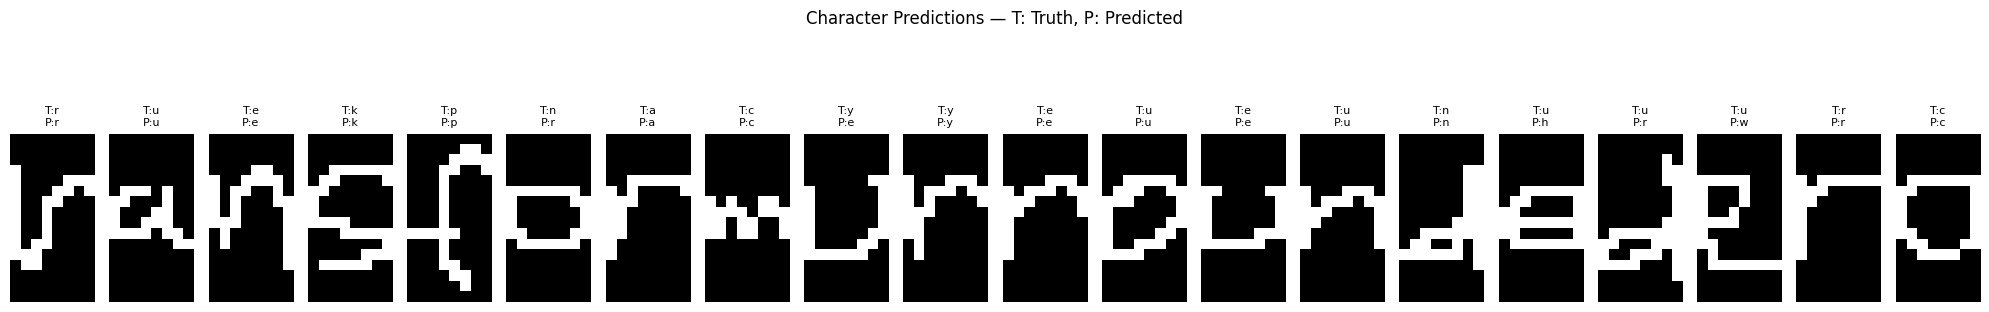

In [17]:
with open(model_path, 'rb') as f:
    crf = pickle.load(f)

# Training Accuracy
y_train_pred = crf.predict(X_train_chars)
y_train_true_flat = [label for seq in y_train_chars for label in seq]
y_train_pred_flat = [label for seq in y_train_pred for label in seq]

train_acc = accuracy_score(y_train_true_flat, y_train_pred_flat)
print(f"Training accuracy: {train_acc:.4f}")

# Testing Accuracy
start_test = timeit.default_timer()
y_pred = crf.predict(X_test_chars)
end_test = timeit.default_timer()
print(f"Testing time elapsed: {end_test - start_test:.2f} s")

y_test_true_flat = [label for seq in y_test_chars for label in seq]
y_test_pred_flat = [label for seq in y_pred for label in seq]

test_acc = accuracy_score(y_test_true_flat, y_test_pred_flat)
print(f"Testing accuracy: {test_acc:.4f}")

# Full word accuracy
y_pred = crf.predict(X_test)
correct = sum(yt == yp for yt, yp in zip(y_test, y_pred))
word_accuracy = correct / len(y_test)
print(f"Full word accuracy: {word_accuracy:.4f}")

features_flat = []
for wid in id_test:
    char_indices = wordid_to_indices[wid]
    for idx in char_indices:
        features_flat.append(dataset['features'][idx])
showFeatures(features_flat, y_test_true_flat, y_test_pred_flat, num=20)

### 1000/4000

In [18]:
features, labels, ids = format(dataset, N, L)
TRAIN = 0.2
model_path = 'crf1_28.obj'

In [19]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = ids[:int(N * TRAIN)], ids[int(N * TRAIN):]

X_train_chars = [seq[:L] for seq in X_train]
X_test_chars = [seq[:L] for seq in X_test]
y_train_chars = [seq[:L] for seq in y_train]
y_test_chars = [seq[:L] for seq in y_test]

y_train = [[i2l(label) for label in seq] for seq in y_train]
y_test = [[i2l(label) for label in seq] for seq in y_test]
y_train_chars = [[i2l(label) for label in seq] for seq in y_train_chars]
y_test_chars = [[i2l(label) for label in seq] for seq in y_test_chars]

In [20]:
crf = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True,
)

start_train = timeit.default_timer()
crf.fit(X_train_chars, y_train_chars)
end_train = timeit.default_timer()
print(f"Training time elapsed: {end_train - start_train:.2f} s")

with open(model_path, 'wb') as f:
    pickle.dump(crf, f)

Training time elapsed: 0.33 s


Training accuracy: 0.9440
Testing time elapsed: 0.11 s
Testing accuracy: 0.7370
Full word accuracy: 0.0343


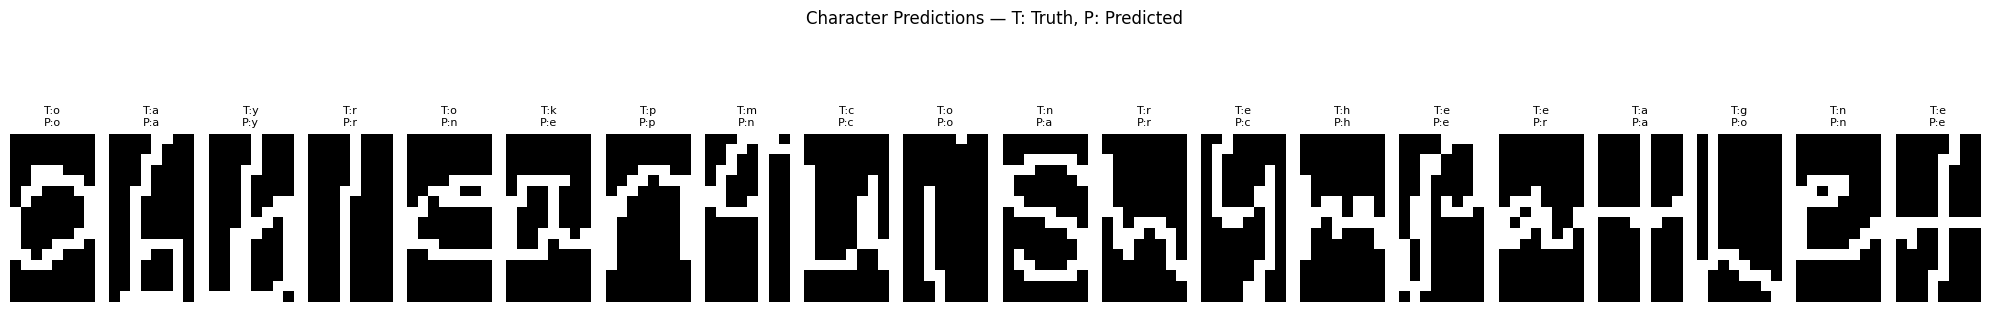

In [21]:
with open(model_path, 'rb') as f:
    crf = pickle.load(f)

# Training Accuracy
y_train_pred = crf.predict(X_train_chars)
y_train_true_flat = [label for seq in y_train_chars for label in seq]
y_train_pred_flat = [label for seq in y_train_pred for label in seq]

train_acc = accuracy_score(y_train_true_flat, y_train_pred_flat)
print(f"Training accuracy: {train_acc:.4f}")

# Testing Accuracy
start_test = timeit.default_timer()
y_pred = crf.predict(X_test_chars)
end_test = timeit.default_timer()
print(f"Testing time elapsed: {end_test - start_test:.2f} s")

y_test_true_flat = [label for seq in y_test_chars for label in seq]
y_test_pred_flat = [label for seq in y_pred for label in seq]

test_acc = accuracy_score(y_test_true_flat, y_test_pred_flat)
print(f"Testing accuracy: {test_acc:.4f}")

# Full word accuracy
y_pred = crf.predict(X_test)
correct = sum(yt == yp for yt, yp in zip(y_test, y_pred))
word_accuracy = correct / len(y_test)
print(f"Full word accuracy: {word_accuracy:.4f}")

features_flat = []
for wid in id_test:
    char_indices = wordid_to_indices[wid]
    for idx in char_indices:
        features_flat.append(dataset['features'][idx])
showFeatures(features_flat, y_test_true_flat, y_test_pred_flat, num=20)

## L = 2

In [22]:
L = 2

### 4000/1000

In [23]:
features, labels, ids = format(dataset, N, L)
TRAIN = 0.8
model_path = 'crf2_82.obj'

In [24]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = ids[:int(N * TRAIN)], ids[int(N * TRAIN):]

X_train_chars = [seq[:L] for seq in X_train]
X_test_chars = [seq[:L] for seq in X_test]
y_train_chars = [seq[:L] for seq in y_train]
y_test_chars = [seq[:L] for seq in y_test]

y_train = [[i2l(label) for label in seq] for seq in y_train]
y_test = [[i2l(label) for label in seq] for seq in y_test]
y_train_chars = [[i2l(label) for label in seq] for seq in y_train_chars]
y_test_chars = [[i2l(label) for label in seq] for seq in y_test_chars]

In [25]:
crf = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True,
)

start_train = timeit.default_timer()
crf.fit(X_train_chars, y_train_chars)
end_train = timeit.default_timer()
print(f"Training time elapsed: {end_train - start_train:.2f} s")

with open(model_path, 'wb') as f:
    pickle.dump(crf, f)

Training time elapsed: 13.95 s


Training accuracy: 0.9872
Testing time elapsed: 0.14 s
Testing accuracy: 0.8565
Full word accuracy: 0.0710


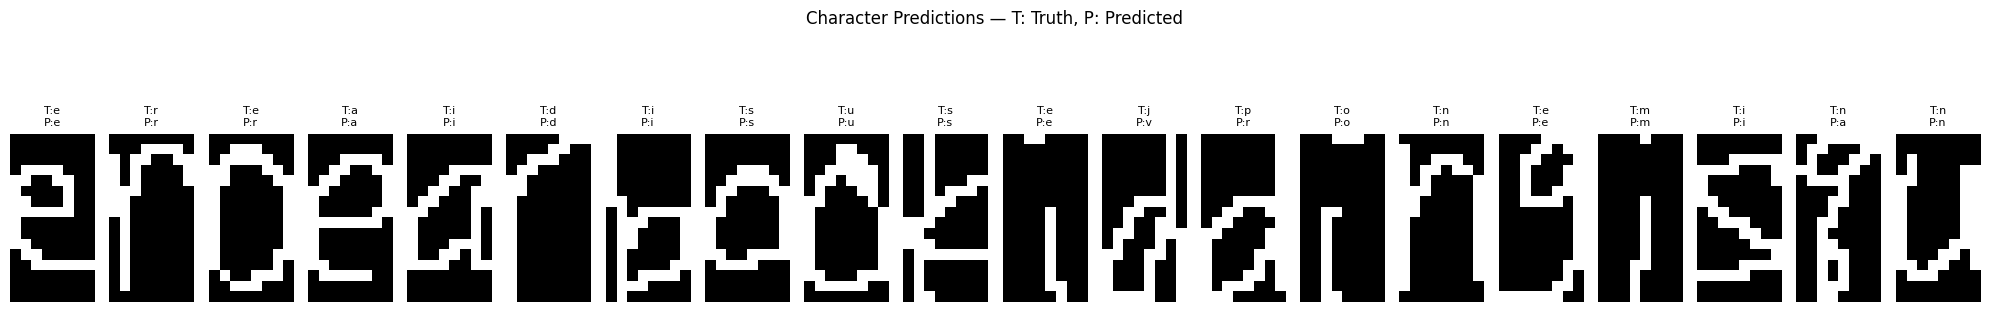

In [26]:
with open(model_path, 'rb') as f:
    crf = pickle.load(f)

# Training Accuracy
y_train_pred = crf.predict(X_train_chars)
y_train_true_flat = [label for seq in y_train_chars for label in seq]
y_train_pred_flat = [label for seq in y_train_pred for label in seq]

train_acc = accuracy_score(y_train_true_flat, y_train_pred_flat)
print(f"Training accuracy: {train_acc:.4f}")

# Testing Accuracy
start_test = timeit.default_timer()
y_pred = crf.predict(X_test_chars)
end_test = timeit.default_timer()
print(f"Testing time elapsed: {end_test - start_test:.2f} s")

y_test_true_flat = [label for seq in y_test_chars for label in seq]
y_test_pred_flat = [label for seq in y_pred for label in seq]

test_acc = accuracy_score(y_test_true_flat, y_test_pred_flat)
print(f"Testing accuracy: {test_acc:.4f}")

# Full word accuracy
y_pred = crf.predict(X_test)
correct = sum(yt == yp for yt, yp in zip(y_test, y_pred))
word_accuracy = correct / len(y_test)
print(f"Full word accuracy: {word_accuracy:.4f}")

features_flat = []
for wid in id_test:
    char_indices = wordid_to_indices[wid]
    for idx in char_indices:
        features_flat.append(dataset['features'][idx])
showFeatures(features_flat, y_test_true_flat, y_test_pred_flat, num=20)

### 2500/2500

In [27]:
features, labels, ids = format(dataset, N, L)
TRAIN = 0.5
model_path = 'crf2_55.obj'

In [28]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = ids[:int(N * TRAIN)], ids[int(N * TRAIN):]

X_train_chars = [seq[:L] for seq in X_train]
X_test_chars = [seq[:L] for seq in X_test]
y_train_chars = [seq[:L] for seq in y_train]
y_test_chars = [seq[:L] for seq in y_test]

y_train = [[i2l(label) for label in seq] for seq in y_train]
y_test = [[i2l(label) for label in seq] for seq in y_test]
y_train_chars = [[i2l(label) for label in seq] for seq in y_train_chars]
y_test_chars = [[i2l(label) for label in seq] for seq in y_test_chars]

In [29]:
crf = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True,
)

start_train = timeit.default_timer()
crf.fit(X_train_chars, y_train_chars)
end_train = timeit.default_timer()
print(f"Training time elapsed: {end_train - start_train:.2f} s")

with open(model_path, 'wb') as f:
    pickle.dump(crf, f)

Training time elapsed: 8.58 s


Training accuracy: 0.9934
Testing time elapsed: 0.36 s
Testing accuracy: 0.8384
Full word accuracy: 0.0660


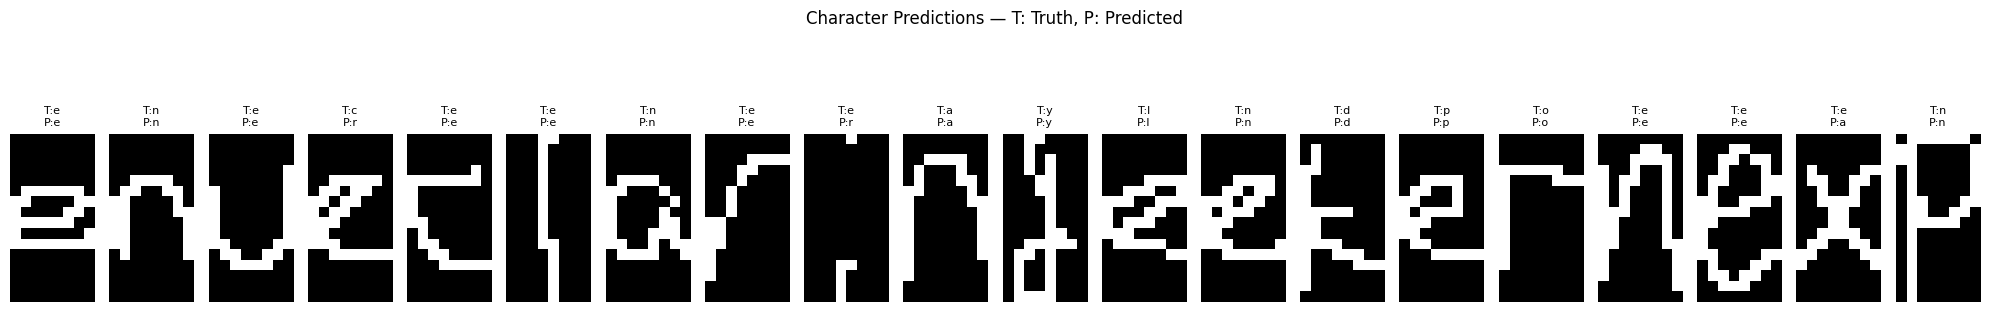

In [30]:
with open(model_path, 'rb') as f:
    crf = pickle.load(f)

# Training Accuracy
y_train_pred = crf.predict(X_train_chars)
y_train_true_flat = [label for seq in y_train_chars for label in seq]
y_train_pred_flat = [label for seq in y_train_pred for label in seq]

train_acc = accuracy_score(y_train_true_flat, y_train_pred_flat)
print(f"Training accuracy: {train_acc:.4f}")

# Testing Accuracy
start_test = timeit.default_timer()
y_pred = crf.predict(X_test_chars)
end_test = timeit.default_timer()
print(f"Testing time elapsed: {end_test - start_test:.2f} s")

y_test_true_flat = [label for seq in y_test_chars for label in seq]
y_test_pred_flat = [label for seq in y_pred for label in seq]

test_acc = accuracy_score(y_test_true_flat, y_test_pred_flat)
print(f"Testing accuracy: {test_acc:.4f}")

# Full word accuracy
y_pred = crf.predict(X_test)
correct = sum(yt == yp for yt, yp in zip(y_test, y_pred))
word_accuracy = correct / len(y_test)
print(f"Full word accuracy: {word_accuracy:.4f}")

features_flat = []
for wid in id_test:
    char_indices = wordid_to_indices[wid]
    for idx in char_indices:
        features_flat.append(dataset['features'][idx])
showFeatures(features_flat, y_test_true_flat, y_test_pred_flat, num=20)

### 1000/4000

In [31]:
features, labels, ids = format(dataset, N, L)
TRAIN = 0.2
model_path = 'crf2_28.obj'

In [32]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = ids[:int(N * TRAIN)], ids[int(N * TRAIN):]

X_train_chars = [seq[:L] for seq in X_train]
X_test_chars = [seq[:L] for seq in X_test]
y_train_chars = [seq[:L] for seq in y_train]
y_test_chars = [seq[:L] for seq in y_test]

y_train = [[i2l(label) for label in seq] for seq in y_train]
y_test = [[i2l(label) for label in seq] for seq in y_test]
y_train_chars = [[i2l(label) for label in seq] for seq in y_train_chars]
y_test_chars = [[i2l(label) for label in seq] for seq in y_test_chars]

In [33]:
crf = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True,
)

start_train = timeit.default_timer()
crf.fit(X_train_chars, y_train_chars)
end_train = timeit.default_timer()
print(f"Training time elapsed: {end_train - start_train:.2f} s")

with open(model_path, 'wb') as f:
    pickle.dump(crf, f)

Training time elapsed: 2.96 s


Training accuracy: 1.0000
Testing time elapsed: 0.55 s
Testing accuracy: 0.7985
Full word accuracy: 0.0522


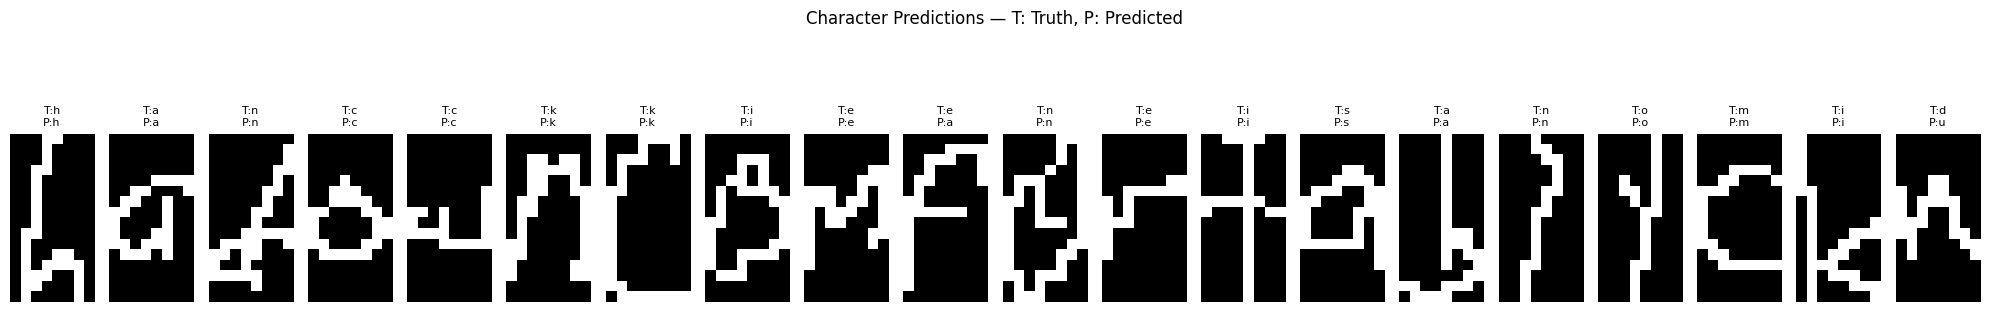

In [34]:
with open(model_path, 'rb') as f:
    crf = pickle.load(f)

# Training Accuracy
y_train_pred = crf.predict(X_train_chars)
y_train_true_flat = [label for seq in y_train_chars for label in seq]
y_train_pred_flat = [label for seq in y_train_pred for label in seq]

train_acc = accuracy_score(y_train_true_flat, y_train_pred_flat)
print(f"Training accuracy: {train_acc:.4f}")

# Testing Accuracy
start_test = timeit.default_timer()
y_pred = crf.predict(X_test_chars)
end_test = timeit.default_timer()
print(f"Testing time elapsed: {end_test - start_test:.2f} s")

y_test_true_flat = [label for seq in y_test_chars for label in seq]
y_test_pred_flat = [label for seq in y_pred for label in seq]

test_acc = accuracy_score(y_test_true_flat, y_test_pred_flat)
print(f"Testing accuracy: {test_acc:.4f}")

# Full word accuracy
y_pred = crf.predict(X_test)
correct = sum(yt == yp for yt, yp in zip(y_test, y_pred))
word_accuracy = correct / len(y_test)
print(f"Full word accuracy: {word_accuracy:.4f}")

features_flat = []
for wid in id_test:
    char_indices = wordid_to_indices[wid]
    for idx in char_indices:
        features_flat.append(dataset['features'][idx])
showFeatures(features_flat, y_test_true_flat, y_test_pred_flat, num=20)

## L = 3

In [35]:
L = 3

### 4000/1000

In [36]:
features, labels, ids = format(dataset, N, L)
TRAIN = 0.8
model_path = 'crf3_82.obj'

In [37]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = ids[:int(N * TRAIN)], ids[int(N * TRAIN):]

X_train_chars = [seq[:L] for seq in X_train]
X_test_chars = [seq[:L] for seq in X_test]
y_train_chars = [seq[:L] for seq in y_train]
y_test_chars = [seq[:L] for seq in y_test]

y_train = [[i2l(label) for label in seq] for seq in y_train]
y_test = [[i2l(label) for label in seq] for seq in y_test]
y_train_chars = [[i2l(label) for label in seq] for seq in y_train_chars]
y_test_chars = [[i2l(label) for label in seq] for seq in y_test_chars]

In [38]:
crf = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True,
)

start_train = timeit.default_timer()
crf.fit(X_train_chars, y_train_chars)
end_train = timeit.default_timer()
print(f"Training time elapsed: {end_train - start_train:.2f} s")

with open(model_path, 'wb') as f:
    pickle.dump(crf, f)

Training time elapsed: 23.89 s


Training accuracy: 0.9868
Testing time elapsed: 0.26 s
Testing accuracy: 0.8510
Full word accuracy: 0.1440


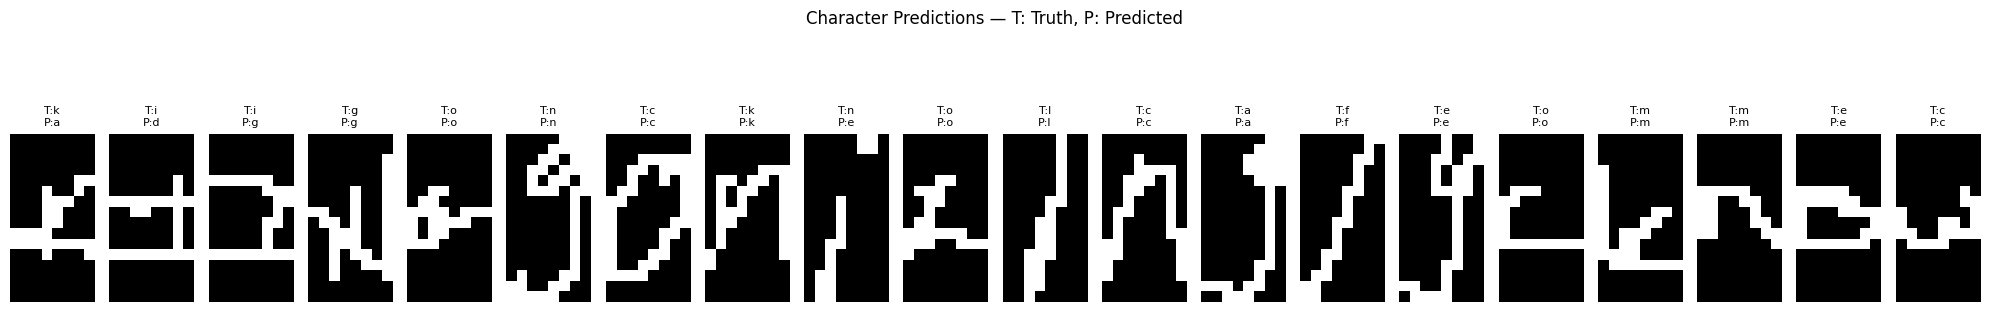

In [39]:
with open(model_path, 'rb') as f:
    crf = pickle.load(f)

# Training Accuracy
y_train_pred = crf.predict(X_train_chars)
y_train_true_flat = [label for seq in y_train_chars for label in seq]
y_train_pred_flat = [label for seq in y_train_pred for label in seq]

train_acc = accuracy_score(y_train_true_flat, y_train_pred_flat)
print(f"Training accuracy: {train_acc:.4f}")

# Testing Accuracy
start_test = timeit.default_timer()
y_pred = crf.predict(X_test_chars)
end_test = timeit.default_timer()
print(f"Testing time elapsed: {end_test - start_test:.2f} s")

y_test_true_flat = [label for seq in y_test_chars for label in seq]
y_test_pred_flat = [label for seq in y_pred for label in seq]

test_acc = accuracy_score(y_test_true_flat, y_test_pred_flat)
print(f"Testing accuracy: {test_acc:.4f}")

# Full word accuracy
y_pred = crf.predict(X_test)
correct = sum(yt == yp for yt, yp in zip(y_test, y_pred))
word_accuracy = correct / len(y_test)
print(f"Full word accuracy: {word_accuracy:.4f}")

features_flat = []
for wid in id_test:
    char_indices = wordid_to_indices[wid]
    for idx in char_indices:
        features_flat.append(dataset['features'][idx])
showFeatures(features_flat, y_test_true_flat, y_test_pred_flat, num=20)

### 2500/2500

In [40]:
features, labels, ids = format(dataset, N, L)
TRAIN = 0.5
model_path = 'crf3_55.obj'

In [41]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = ids[:int(N * TRAIN)], ids[int(N * TRAIN):]

X_train_chars = [seq[:L] for seq in X_train]
X_test_chars = [seq[:L] for seq in X_test]
y_train_chars = [seq[:L] for seq in y_train]
y_test_chars = [seq[:L] for seq in y_test]

y_train = [[i2l(label) for label in seq] for seq in y_train]
y_test = [[i2l(label) for label in seq] for seq in y_test]
y_train_chars = [[i2l(label) for label in seq] for seq in y_train_chars]
y_test_chars = [[i2l(label) for label in seq] for seq in y_test_chars]

In [42]:
crf = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True,
)

start_train = timeit.default_timer()
crf.fit(X_train_chars, y_train_chars)
end_train = timeit.default_timer()
print(f"Training time elapsed: {end_train - start_train:.2f} s")

with open(model_path, 'wb') as f:
    pickle.dump(crf, f)

Training time elapsed: 14.41 s


Training accuracy: 0.9931
Testing time elapsed: 0.69 s
Testing accuracy: 0.8460
Full word accuracy: 0.1536


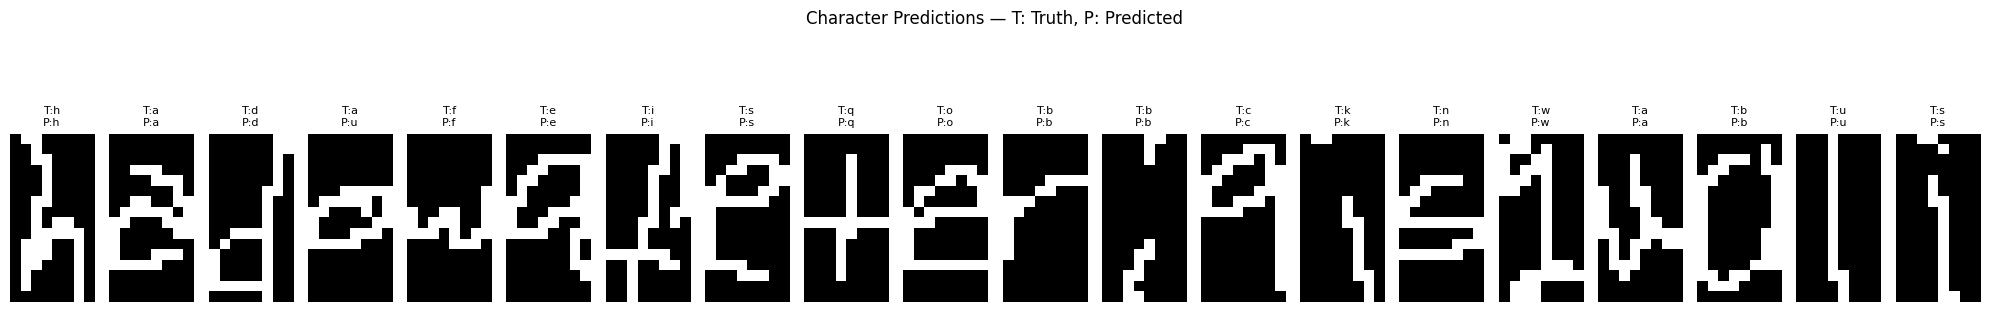

In [43]:
with open(model_path, 'rb') as f:
    crf = pickle.load(f)

# Training Accuracy
y_train_pred = crf.predict(X_train_chars)
y_train_true_flat = [label for seq in y_train_chars for label in seq]
y_train_pred_flat = [label for seq in y_train_pred for label in seq]

train_acc = accuracy_score(y_train_true_flat, y_train_pred_flat)
print(f"Training accuracy: {train_acc:.4f}")

# Testing Accuracy
start_test = timeit.default_timer()
y_pred = crf.predict(X_test_chars)
end_test = timeit.default_timer()
print(f"Testing time elapsed: {end_test - start_test:.2f} s")

y_test_true_flat = [label for seq in y_test_chars for label in seq]
y_test_pred_flat = [label for seq in y_pred for label in seq]

test_acc = accuracy_score(y_test_true_flat, y_test_pred_flat)
print(f"Testing accuracy: {test_acc:.4f}")

# Full word accuracy
y_pred = crf.predict(X_test)
correct = sum(yt == yp for yt, yp in zip(y_test, y_pred))
word_accuracy = correct / len(y_test)
print(f"Full word accuracy: {word_accuracy:.4f}")

features_flat = []
for wid in id_test:
    char_indices = wordid_to_indices[wid]
    for idx in char_indices:
        features_flat.append(dataset['features'][idx])
showFeatures(features_flat, y_test_true_flat, y_test_pred_flat, num=20)

### 1000/4000

In [44]:
features, labels, ids = format(dataset, N, L)
TRAIN = 0.2
model_path = 'crf3_28.obj'

In [45]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = ids[:int(N * TRAIN)], ids[int(N * TRAIN):]

X_train_chars = [seq[:L] for seq in X_train]
X_test_chars = [seq[:L] for seq in X_test]
y_train_chars = [seq[:L] for seq in y_train]
y_test_chars = [seq[:L] for seq in y_test]

y_train = [[i2l(label) for label in seq] for seq in y_train]
y_test = [[i2l(label) for label in seq] for seq in y_test]
y_train_chars = [[i2l(label) for label in seq] for seq in y_train_chars]
y_test_chars = [[i2l(label) for label in seq] for seq in y_test_chars]

In [46]:
crf = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True,
)

start_train = timeit.default_timer()
crf.fit(X_train_chars, y_train_chars)
end_train = timeit.default_timer()
print(f"Training time elapsed: {end_train - start_train:.2f} s")

with open(model_path, 'wb') as f:
    pickle.dump(crf, f)

Training time elapsed: 6.02 s


Training accuracy: 0.9990
Testing time elapsed: 1.03 s
Testing accuracy: 0.7918
Full word accuracy: 0.1378


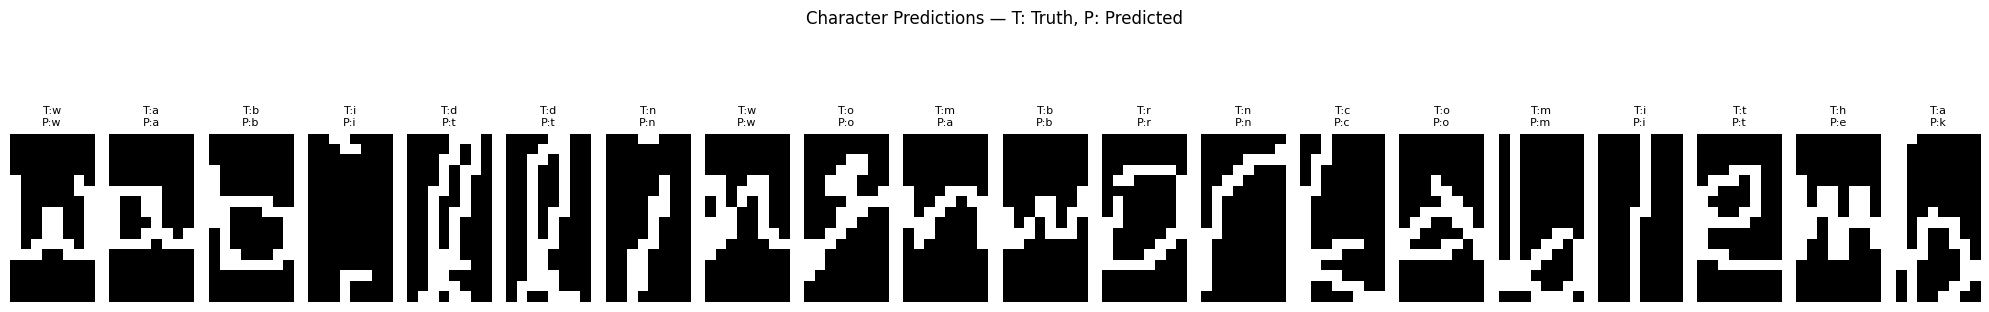

In [47]:
with open(model_path, 'rb') as f:
    crf = pickle.load(f)

# Training Accuracy
y_train_pred = crf.predict(X_train_chars)
y_train_true_flat = [label for seq in y_train_chars for label in seq]
y_train_pred_flat = [label for seq in y_train_pred for label in seq]

train_acc = accuracy_score(y_train_true_flat, y_train_pred_flat)
print(f"Training accuracy: {train_acc:.4f}")

# Testing Accuracy
start_test = timeit.default_timer()
y_pred = crf.predict(X_test_chars)
end_test = timeit.default_timer()
print(f"Testing time elapsed: {end_test - start_test:.2f} s")

y_test_true_flat = [label for seq in y_test_chars for label in seq]
y_test_pred_flat = [label for seq in y_pred for label in seq]

test_acc = accuracy_score(y_test_true_flat, y_test_pred_flat)
print(f"Testing accuracy: {test_acc:.4f}")

# Full word accuracy
y_pred = crf.predict(X_test)
correct = sum(yt == yp for yt, yp in zip(y_test, y_pred))
word_accuracy = correct / len(y_test)
print(f"Full word accuracy: {word_accuracy:.4f}")

features_flat = []
for wid in id_test:
    char_indices = wordid_to_indices[wid]
    for idx in char_indices:
        features_flat.append(dataset['features'][idx])
showFeatures(features_flat, y_test_true_flat, y_test_pred_flat, num=20)